----

### 참여 대회 주제 및 URL

- 주어진 고객 데이터셋(나이, 성별, 월 수입 등)을 이용해 __여행 패키지 신청 여부를 예측__
- https://dacon.io/competitions/official/235959/overview/description

### 최종 순위

- PRIVATE 48위(13.15%) / PUBLIC 34위(9.32%) ㅡ 총 365명 참가

--------

# 목차

1. EDA & Filling Null 
  
    1.1 train, test set 불러오기  
    1.2 feature 분석    
    1.3 msno를 통해 Null값 여부 확인    
    
      
2. Data Preprocessing

    2.1 pd.get_dummies와 map  
    2.2 정규화(MinMaxScaler)
    
      
3. Predictive Modeling 

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=1)

import missingno as msno 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

# 1. EDA & Filling Null

## 1.1 train, test set 불러오기

In [157]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [158]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1945 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

0번 부터 18번까지는 train에 필요한 feature이고,   
19번 __ProdTaken__이 우리가 예측해야 할 여행 패키지 신청 여부이다.  

(아래의 test data에는 ProdTaken이 없음을 확인 할 수 있다.)

In [159]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2933 non-null   int64  
 1   Age                       2801 non-null   float64
 2   TypeofContact             2918 non-null   object 
 3   CityTier                  2933 non-null   int64  
 4   DurationOfPitch           2784 non-null   float64
 5   Occupation                2933 non-null   object 
 6   Gender                    2933 non-null   object 
 7   NumberOfPersonVisiting    2933 non-null   int64  
 8   NumberOfFollowups         2901 non-null   float64
 9   ProductPitched            2933 non-null   object 
 10  PreferredPropertyStar     2917 non-null   float64
 11  MaritalStatus             2933 non-null   object 
 12  NumberOfTrips             2850 non-null   float64
 13  Passport                  2933 non-null   int64  
 14  PitchSat

<< 데이터의 feature에 대한 설명 >>

Age : 나이  
TypeofContact : 고객의 제품 인지 방법 (회사의 홍보 or 스스로 검색)  
CityTier : 주거 중인 도시의 등급 (인구, 시설, 생활 수준 기준) (1등급 > 2등급 > 3등급)   
DurationOfPitch : 영업 사원이 고객에게 제공하는 프레젠테이션 기간  
Occupation : 직업  
Gender : 성별  
NumberOfPersonVisiting : 고객과 함께 여행을 계획 중인 총 인원  
NumberOfFollowups : 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수  
ProductPitched : 영업 사원이 제시한 상품  
PreferredPropertyStar : 선호 호텔 숙박업소 등급  
MaritalStatus : 결혼여부  
NumberOfTrips : 평균 연간 여행 횟수  
Passport : 여권 보유 여부 (0: 없음, 1: 있음)  
PitchSatisfactionScore : 영업 사원의 프레젠테이션 만족도  
OwnCar : 자동차 보유 여부 (0: 없음, 1: 있음)  
NumberOfChildrenVisiting : 함께 여행을 계획 중인 5세 미만의 어린이 수  
Designation : (직업의) 직급  
MonthlyIncome : 월 급여  
  
ProdTaken : 여행 패키지 신청 여부 (0: 신청 안 함, 1: 신청함) - 예측해야 할 항목

train과 test data를 살펴보면 몇 개의 feature에서 Null값이 있음을 알 수 있다.  
각각의 feature에 대해 EDA 해보고, 적절한 Null값을 채워보고자 한다.

## 1.2 feature 분석

- Null이 존재하는 feature 위주로 분석을 시행해보았다.

###  1.2.1 Age - 나이

In [160]:
train['Age'].isnull().sum()

94

In [161]:
train['Age'].describe()

count    1861.000000
mean       37.462117
std         9.189948
min        18.000000
25%        31.000000
50%        36.000000
75%        43.000000
max        61.000000
Name: Age, dtype: float64

94개의 Null값이 존재하며, 나이의 평균은 37.47임을 알 수 있다.

<AxesSubplot:xlabel='Age', ylabel='Count'>

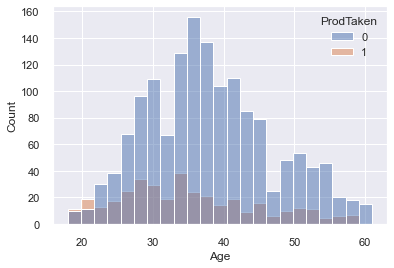

In [162]:
sns.histplot(data=train, x='Age', hue='ProdTaken')

Age와 ProdTaken에 대한 histogram을 그려보았다.  

(1) 20대 초반 : 여행상품을 산 사람 > 안 산 사람  
(2) 30대 중반 : 여행상품을 안 산 사람 > 산 사람  
(3) 그 외 두드러지게 보이는 부분은 없음

(자기 반성) 여기서 분명 ProdTaken과의 관계를 확인했으나, 이것을 반영할 수 있는 Age band와 같은 수단을 사용하지 않았다. - 대회 참가 당시 5, 10살 기준으로 Age band를 만들어 예측을 수행한 결과, public 정확도가 오히려 떨어짐을 확인해서 그 이후로는 사용하지 않았다. 결국은 public에서 과적합이 일어나 private에서 정확도가 더 떨어진 것으로 보인다.

In [163]:
train.groupby('Designation').mean()

,id,Age,CityTier,DurationOfPitch,NumberOfPersonVisiting,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,MonthlyIncome,ProdTaken
Designation,,,,,,,,,,,,,,
AVP,997.938462,48.153846,1.730769,16.423077,2.800000,3.623077,3.538462,3.620370,0.292308,3.269231,0.715385,1.103448,32148.438462,0.076923
Executive,978.582550,32.742775,1.318121,14.912378,2.962416,3.694595,3.587366,3.144011,0.312752,3.116779,0.573154,1.229530,20110.209859,0.299329
Manager,955.802612,37.235747,1.921626,16.154723,2.918723,3.688693,3.557329,3.246734,0.275762,3.020319,0.621190,1.210450,22614.373397,0.130624
Senior Manager,996.344371,41.235880,1.807947,16.172757,2.894040,3.837748,3.621262,3.392027,0.278146,2.913907,0.658940,1.182119,26715.056291,0.168874
VP,1053.595506,47.426966,1.483146,12.606742,2.898876,3.876404,3.345679,3.403509,0.269663,3.247191,0.719101,1.368421,35796.179775,0.101124


나중에 살펴볼 feature 중 Designation(직급)이 나이의 특성을 잘 반영할 것이라 판단하여,  
groupby를 이용해 직급별 평균 나이를 구하고 이를 age Null값에 채우고자 한다.

In [164]:
train.loc[(train.Age.isnull()) & (train.Designation == 'AVP'),'Age'] = 49
train.loc[(train.Age.isnull()) & (train.Designation == 'Executive'),'Age'] = 33
train.loc[(train.Age.isnull()) & (train.Designation == 'Manager'),'Age'] = 38
train.loc[(train.Age.isnull()) & (train.Designation == 'Senior Manager'),'Age'] = 42
train.loc[(train.Age.isnull()) & (train.Designation == 'VP'),'Age'] = 48

In [165]:
train['Age'].isnull().sum()

0

#### test data에도 적용 - data leakage를 방지하기 위해 train의 평균 age를 채움

In [166]:
test.loc[(test.Age.isnull()) & (test.Designation == 'AVP'),'Age'] = 49
test.loc[(test.Age.isnull()) & (test.Designation == 'Executive'),'Age'] = 33
test.loc[(test.Age.isnull()) & (test.Designation == 'Manager'),'Age'] = 38
test.loc[(test.Age.isnull()) & (test.Designation == 'Senior Manager'),'Age'] = 42
test.loc[(test.Age.isnull()) & (test.Designation == 'VP'),'Age'] = 48

In [167]:
test['Age'].isnull().sum()

0

### 1.2.2 TypeofContact - 고객의 제품 인지 방법 

In [168]:
train['TypeofContact'].isnull().sum()

10

In [169]:
train['TypeofContact'].value_counts()

Self Enquiry       1379
Company Invited     566
Name: TypeofContact, dtype: int64

TypeofContact의 고유값으로는 Self Enquiry(스스로 검색), Company Invited(회사의 홍보) 2가지가 있으며, 해당 feature의 null값 10개를 최빈값인 Self Enquiry로 채웠다.

In [170]:
train['TypeofContact'].fillna('Self Enquiry',inplace=True)

In [171]:
train['TypeofContact'].isnull().sum()

0

#### test data에도 적용 - data leakage를 방지하기 위해 train 값에 대한 값을 채움

In [172]:
test['TypeofContact'].fillna('Self Enquiry',inplace=True)

In [173]:
test['TypeofContact'].isnull().sum()

0

### 1.2.3 DurationOfPitch - 영업 사원이 고객에게 제공하는 프레젠테이션 기간

In [174]:
train['DurationOfPitch'].describe()

count    1853.000000
mean       15.524015
std         8.150057
min         5.000000
25%         9.000000
50%        14.000000
75%        20.000000
max        36.000000
Name: DurationOfPitch, dtype: float64

In [175]:
train['DurationOfPitch'].median()

14.0

Null값을 채우기 위해 다른 feature와 연계해보거나, 평균 값을 넣어보는 시도를 해봤지만 정확도에 큰 차이가 나지 않아 중앙값인 14를 넣어주었다.

In [176]:
train['DurationOfPitch'].fillna(14, inplace=True)

In [177]:
train['DurationOfPitch'].isnull().sum()

0

In [178]:
test['DurationOfPitch'].isnull().sum()

149

#### test data에도 적용 - data leakage를 방지하기 위해 train 값에 대한 값을 채움

In [179]:
test['DurationOfPitch'].fillna(14, inplace=True) 

In [180]:
test['DurationOfPitch'].isnull().sum()

0

### 1.2.4 NumberOfFollowups - 영업 사원의 프레젠테이션 후 이루어진 후속 조치 수

In [181]:
train['NumberOfFollowups'].isnull().sum()

13

후속 조치가 없었다고 생각하여 Null값을 0으로 채워주었고, test data에도 동일하게 적용했다.

In [182]:
train['NumberOfFollowups'].fillna(0, inplace=True)

In [183]:
test['NumberOfFollowups'].fillna(0, inplace=True)

### 1.2.5 Gender - 성별

In [184]:
train['Gender'].value_counts()

Male       1207
Female      692
Fe Male      56
Name: Gender, dtype: int64

replace를 이용해 Fe Male을 Female로 변경했다.

In [185]:
train['Gender'].replace('Fe Male','Female',inplace=True)

In [186]:
train['Gender'].value_counts()

Male      1207
Female     748
Name: Gender, dtype: int64

test data에도 같은 수정사항을 반영했다.

In [187]:
test['Gender'].replace('Fe Male','Female',inplace=True)

In [188]:
test['Gender'].value_counts()

Male      1709
Female    1224
Name: Gender, dtype: int64

### 1.2.6 NumberOfChildrenVisiting - 함께 여행을 계획 중인 5세 미만의 어린이 수

In [189]:
train['NumberOfChildrenVisiting'].value_counts()

1.0    819
2.0    559
0.0    416
3.0    134
Name: NumberOfChildrenVisiting, dtype: int64

train의 최빈값인 1.0으로 train, test Null값을 채웠다.

In [190]:
train['NumberOfChildrenVisiting'].fillna(1.0, inplace=True)

In [191]:
test['NumberOfChildrenVisiting'].fillna(1.0, inplace=True)

### 1.2.7 PreferredPropertyStar - 선호 호텔 숙박업소 등급

In [192]:
train['PreferredPropertyStar'].value_counts()

3.0    1212
5.0     373
4.0     360
Name: PreferredPropertyStar, dtype: int64

train의 최빈값인 3.0으로 train, test Null값을 채웠다.

In [193]:
train['PreferredPropertyStar'].fillna(3.0, inplace=True)

In [194]:
test['PreferredPropertyStar'].fillna(3.0, inplace=True)

### 1.2.8 NumberOfTrips - 평균 연간 여행횟수

In [195]:
train['NumberOfTrips'].describe()

count    1898.000000
mean        3.255532
std         1.814698
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        19.000000
Name: NumberOfTrips, dtype: float64

In [196]:
train['NumberOfTrips'].median()

3.0

train의 중앙값인 3.0으로 train, test Null값을 채웠다.

In [197]:
train['NumberOfTrips'].fillna(3.0, inplace=True)

In [198]:
test['NumberOfTrips'].fillna(3.0, inplace=True)

### 1.2.8 MonthlyIncome - 월 급여

In [199]:
train.groupby('Designation').mean()['MonthlyIncome']

Designation
AVP               32148.438462
Executive         20110.209859
Manager           22614.373397
Senior Manager    26715.056291
VP                35796.179775
Name: MonthlyIncome, dtype: float64

월 급여는 직급에 따라 Null값을 채우는 것이 가장 좋을 것이라 판단하여  
직급에 따른 월 급여를 산출했고, 이 값을 train, test의 Null값에 동일하게 입력했다.

In [200]:
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='AVP'),'MonthlyIncome'] = 32149
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='Executive'),'MonthlyIncome'] = 20111
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='Manager'),'MonthlyIncome'] = 22615
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='Senior Manager'),'MonthlyIncome'] = 26716
train.loc[(train.MonthlyIncome.isnull()) & (train.Designation=='VP'),'MonthlyIncome']  = 35797

In [201]:
train.MonthlyIncome.isnull().sum()

0

#### test data에도 적용 - data leakage를 방지하기 위해 train 값에 대한 값을 채움

In [202]:
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='AVP'),'MonthlyIncome'] = 32149
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='Executive'),'MonthlyIncome'] = 20111
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='Manager'),'MonthlyIncome'] = 22615
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='Senior Manager'),'MonthlyIncome'] = 26716
test.loc[(test.MonthlyIncome.isnull()) & (test.Designation=='VP'),'MonthlyIncome']  = 35797

In [203]:
test.MonthlyIncome.isnull().sum()

0

## 1.3 msno를 통해 Null값 여부 확인

<AxesSubplot:>

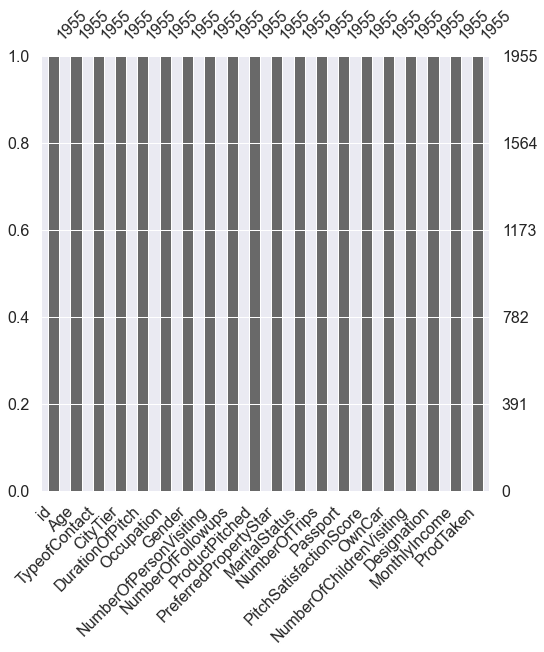

In [204]:
msno.bar(df=train,figsize=(8,8))

<AxesSubplot:>

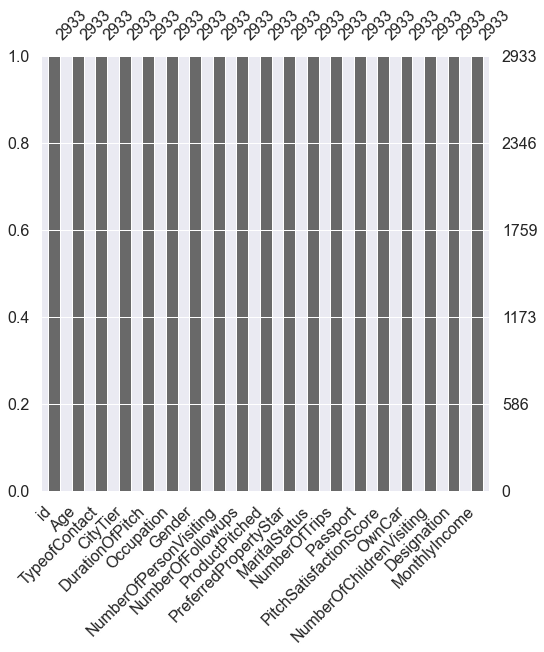

In [205]:
msno.bar(df=test,figsize=(8,8))

# 2. Data Preprocessing

## 2.1 pd.get_dummies와 map

In [206]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1955 non-null   float64
 2   TypeofContact             1955 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1955 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1955 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1955 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1955 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

train data 중 object에 해당하는 column을 pd.get_dummies를 이용해 더미변수를 생성하고, map을 이용해 Gender를 0과 1로 변환했다.

In [207]:
train['Gender'] = train['Gender'].map({'Male' : 0, 'Female' : 1})

In [208]:
train = pd.get_dummies(train, columns=['TypeofContact'], prefix='TC')

In [209]:
train = pd.get_dummies(train, columns=['CityTier'], prefix='CityTier')

In [210]:
train = pd.get_dummies(train, columns=['Occupation'], prefix='Occ')

In [211]:
train = pd.get_dummies(train, columns=['ProductPitched'], prefix='Pitched')

In [212]:
train = pd.get_dummies(train, columns=['MaritalStatus'], prefix='Marry')

In [213]:
train = pd.get_dummies(train, columns=['Designation'], prefix='Desig')

In [214]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1955 non-null   float64
 2   DurationOfPitch           1955 non-null   float64
 3   Gender                    1955 non-null   int64  
 4   NumberOfPersonVisiting    1955 non-null   int64  
 5   NumberOfFollowups         1955 non-null   float64
 6   PreferredPropertyStar     1955 non-null   float64
 7   NumberOfTrips             1955 non-null   float64
 8   Passport                  1955 non-null   int64  
 9   PitchSatisfactionScore    1955 non-null   int64  
 10  OwnCar                    1955 non-null   int64  
 11  NumberOfChildrenVisiting  1955 non-null   float64
 12  MonthlyIncome             1955 non-null   float64
 13  ProdTaken                 1955 non-null   int64  
 14  TC_Compa

test도 train과 같은 방법으로 변환해주었다.

In [215]:
test['Gender'] = test['Gender'].map({'Male' : 0, 'Female' : 1})

In [216]:
test = pd.get_dummies(test, columns=['TypeofContact'], prefix='TC')

In [217]:
test = pd.get_dummies(test, columns=['CityTier'], prefix='CityTier')

In [218]:
test = pd.get_dummies(test, columns=['Occupation'], prefix='Occ')

In [219]:
test = pd.get_dummies(test, columns=['ProductPitched'], prefix='Pitched')

In [220]:
test = pd.get_dummies(test, columns=['MaritalStatus'], prefix='Marry')

In [221]:
test = pd.get_dummies(test, columns=['Designation'], prefix='Desig')

In [222]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2933 entries, 0 to 2932
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        2933 non-null   int64  
 1   Age                       2933 non-null   float64
 2   DurationOfPitch           2933 non-null   float64
 3   Gender                    2933 non-null   int64  
 4   NumberOfPersonVisiting    2933 non-null   int64  
 5   NumberOfFollowups         2933 non-null   float64
 6   PreferredPropertyStar     2933 non-null   float64
 7   NumberOfTrips             2933 non-null   float64
 8   Passport                  2933 non-null   int64  
 9   PitchSatisfactionScore    2933 non-null   int64  
 10  OwnCar                    2933 non-null   int64  
 11  NumberOfChildrenVisiting  2933 non-null   float64
 12  MonthlyIncome             2933 non-null   float64
 13  TC_Company Invited        2933 non-null   uint8  
 14  TC_Self 

## 2.2 정규화(MinMaxScaler)

Age(나이)와 MonthlyIncome(월 급여)는 같은 숫자 데이터지만 숫자의 범위가 크게 차이가 나므로 이 점을 보완하고자 숫자 데이터인 __Age, DurationOfPitch, MonthlyIncome__에 대해 정규화를 수행해주었다.

In [223]:
from sklearn.preprocessing import MinMaxScaler

In [224]:
train_scale = train[['Age','DurationOfPitch','MonthlyIncome']]

In [225]:
scaler = MinMaxScaler()
scaler.fit(train_scale)
train[['Age','DurationOfPitch','MonthlyIncome']] = scaler.transform(train_scale)

In [226]:
train[['Age','DurationOfPitch','MonthlyIncome']]

,Age,DurationOfPitch,MonthlyIncome
0,0.232558,0.161290,0.198448
1,0.372093,0.290323,0.190411
2,0.627907,0.290323,0.221288
3,0.255814,0.064516,0.207560
4,0.558140,0.032258,0.193565
...,...,...,...
1950,0.232558,0.161290,0.201919
1951,0.534884,0.096774,0.313223
1952,0.465116,0.741935,0.211419
1953,0.232558,0.806452,0.217224


test에도 같은 데이터에 대해 정규화를 시행해준다.

In [227]:
test[['Age','DurationOfPitch','MonthlyIncome']] = scaler.transform(test[['Age','DurationOfPitch','MonthlyIncome']])

In [228]:
test[['Age','DurationOfPitch','MonthlyIncome']]

,Age,DurationOfPitch,MonthlyIncome
0,0.325581,0.290323,0.191118
1,0.651163,0.193548,0.194732
2,0.441860,0.548387,0.208174
3,0.581395,1.000000,0.224718
4,0.162791,0.064516,0.213764
...,...,...,...
2928,0.837209,0.032258,0.320727
2929,0.348837,0.129032,0.232734
2930,0.348837,0.838710,0.235334
2931,0.186047,0.129032,0.216036


# 3. Predictive Modeling

## 3.1 Heatmap

feature간의 상관관계를 알아보기 위해 Heatmap을 그려보고자 한다.

In [229]:
train.columns

Index(['id', 'Age', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome', 'ProdTaken',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Pitched_Basic', 'Pitched_Deluxe', 'Pitched_King',
       'Pitched_Standard', 'Pitched_Super Deluxe', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager', 'Desig_VP'],
      dtype='object')

In [230]:
train_corr = train[['Age', 'DurationOfPitch', 'Gender', 'NumberOfPersonVisiting',
       'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips',
       'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'MonthlyIncome',
       'TC_Company Invited', 'TC_Self Enquiry', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'Occ_Free Lancer', 'Occ_Large Business', 'Occ_Salaried',
       'Occ_Small Business', 'Pitched_Basic', 'Pitched_Deluxe', 'Pitched_King',
       'Pitched_Standard', 'Pitched_Super Deluxe', 'Marry_Divorced',
       'Marry_Married', 'Marry_Single', 'Marry_Unmarried', 'Desig_AVP',
       'Desig_Executive', 'Desig_Manager', 'Desig_Senior Manager',
       'Desig_VP','ProdTaken']]

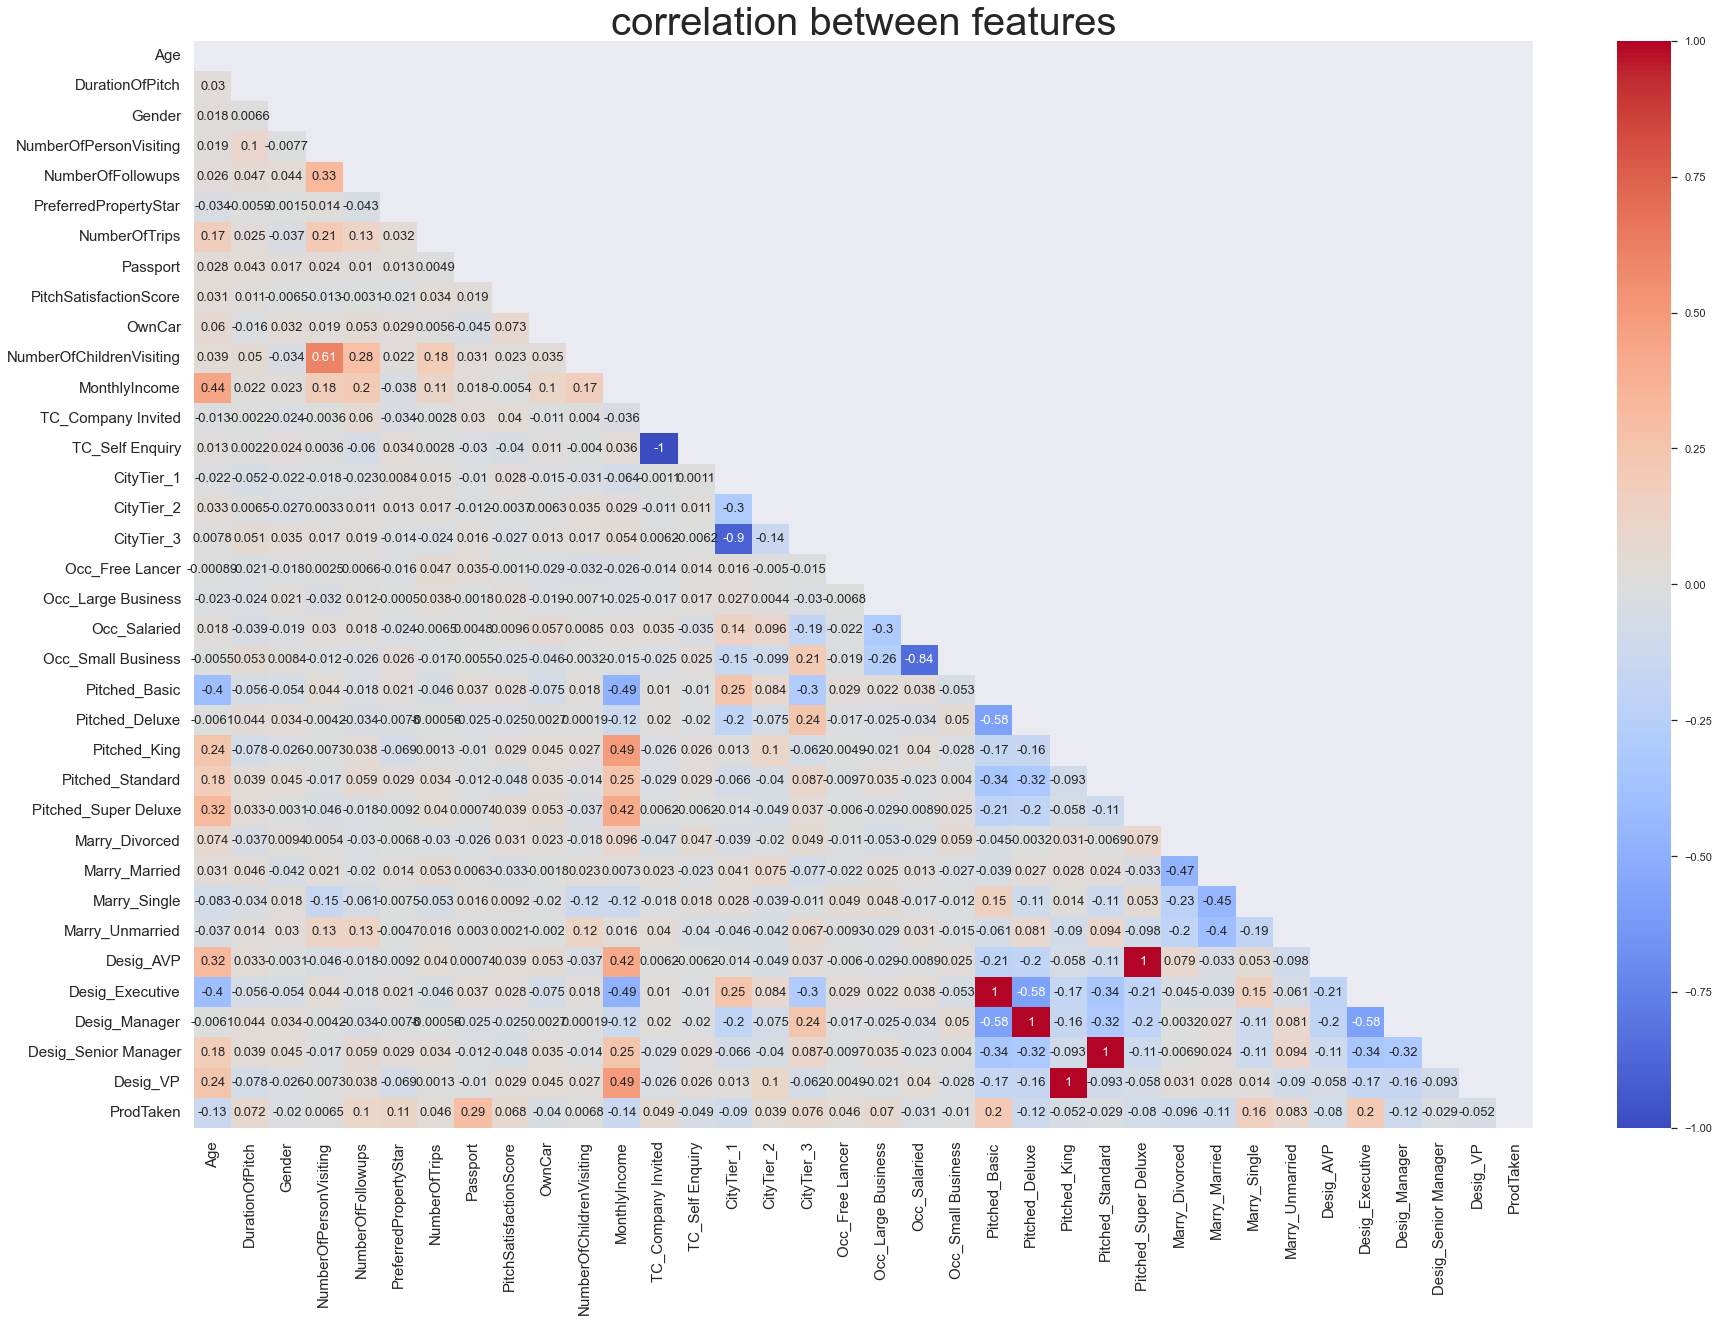

In [231]:
plt.figure(figsize=(30,20))

heat_table = train_corr.corr()
mask = np.zeros_like(heat_table)
mask[np.triu_indices_from(mask)] = True
heatmap_ax = sns.heatmap(heat_table, annot=True, annot_kws={'size':13}, mask = mask, cmap='coolwarm', vmin=-1, vmax=1)
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=15, rotation=90)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=15)
plt.title('correlation between features', fontsize=40)
plt.show()

- 직급(Designation)과 제시상품(ProductPitched)에서 상관관계